# Exploratory Data Analysis (EDA)

This notebook visualizes the audio data to:
1.  Confirm audio is loaded correctly (16kHz, normalized).
2.  Analyze duration distribution (determines optimal UAP vector length).
3.  Visualize waveforms and Mel-spectrograms.
4.  Check amplitude statistics.

In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import torch
from IPython.display import Audio, display

import src.data as data_loader

## Load and Verify Audio Pipeline

We load a few sample audio files to ensure the `audio_loader.py` functions work as expected (16kHz resampling, float32 normalization).

In [12]:
_ = data_loader.download_librispeech_sample() 

# validate that the sample files are present
sample_paths = data_loader.get_librispeech_files()
print(f"Found {len(sample_paths)} audio files.")

if len(sample_paths) > 0:
    print(f"Sample: {sample_paths[0]}")
else:
    print("WARNING: No audio files found. Check download.")

Checking/Downloading LibriSpeech (test-clean) to: /Users/victorhugogermano/Development/soundfinal/data


100%|██████████| 331M/331M [00:20<00:00, 17.3MB/s] 


Found 2620 audio files.
Sample: /Users/victorhugogermano/Development/soundfinal/data/LibriSpeech/test-clean/61/70970/61-70970-0040.flac


## Duration Distribution Analysis

Whisper processes fixed-length inputs (e.g., 30s chunks). We need to know the distribution of our data to decide how to handle variable-length utterances.
- If audio > 30s: We will tile the perturbation or crop the audio.
- If audio < 30s: We need to handle short sequences.

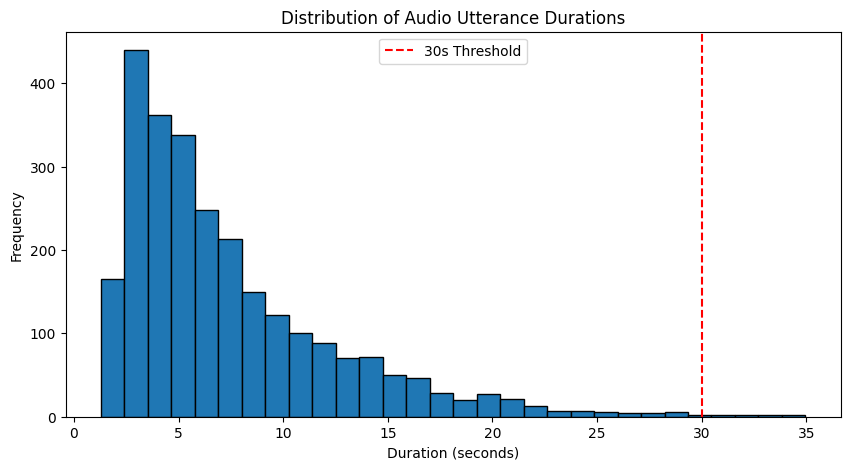

Mean Duration: 7.42s
Max Duration: 34.95s


In [13]:
durations = []
for path in sample_paths:
    dur = data_loader.get_audio_duration(path)
    durations.append(dur)

plt.figure(figsize=(10, 5))
plt.hist(durations, bins=30, edgecolor='black')
plt.axvline(x=30, color='r', linestyle='--', label='30s Threshold')
plt.title('Distribution of Audio Utterance Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Mean Duration: {np.mean(durations):.2f}s")
print(f"Max Duration: {np.max(durations):.2f}s")

## Visualize Waveforms and Mel-Spectrograms

Visualizing the Mel-spectrogram is crucial because Whisper operates on this representation.

Loading audio from: /Users/victorhugogermano/Development/soundfinal/data/LibriSpeech/test-clean/61/70970/61-70970-0040.flac
Sample Rate: 16000 Hz, Audio Shape: torch.Size([66640])


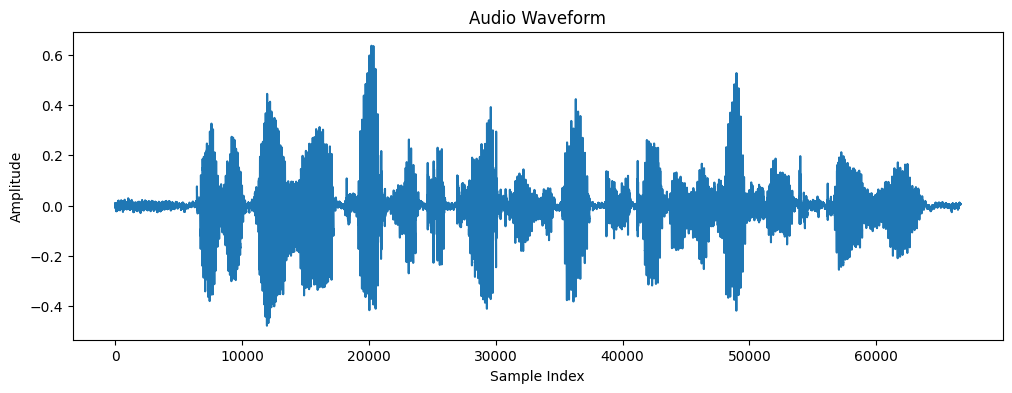

In [14]:
# Visualizing a sample audio file

if len(sample_paths) > 0:
    sample_path = sample_paths[0]
    print(f"Loading audio from: {sample_path}")
    audio = data_loader.load_audio(sample_path)
    print(f"Sample Rate: {data_loader.TARGET_SAMPLE_RATE} Hz, Audio Shape: {audio.shape}")

    plt.figure(figsize=(12, 4))
    plt.plot(audio)
    plt.title('Audio Waveform')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()

    display(Audio(audio, rate=data_loader.TARGET_SAMPLE_RATE))
else:
    print("No audio files to visualize.")      

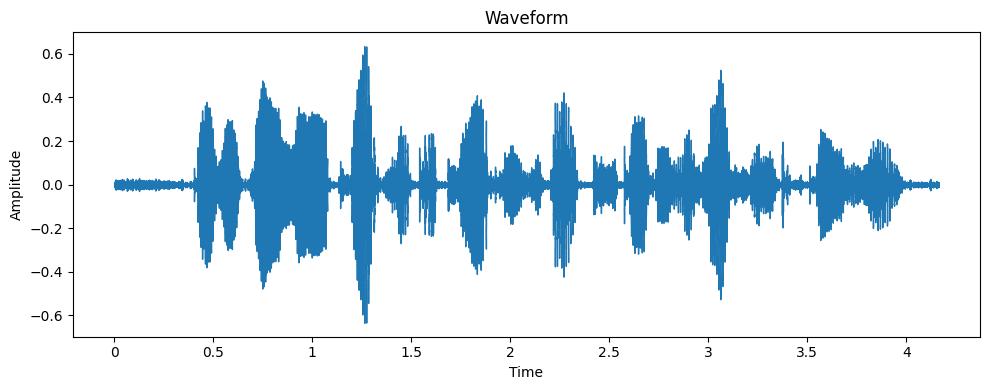

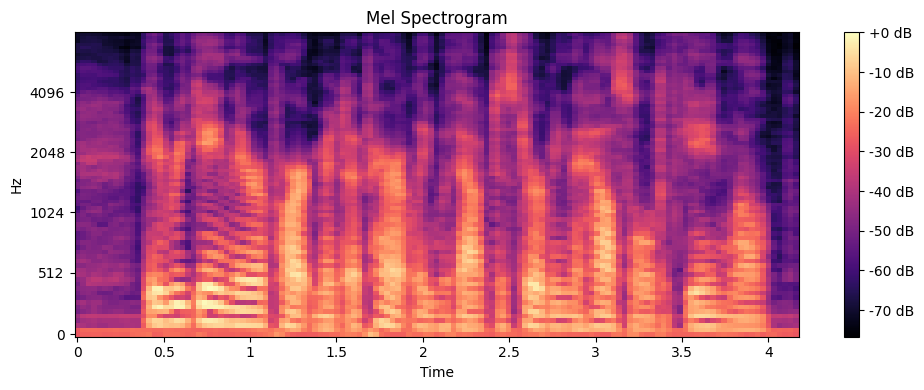

In [15]:
def plot_mel_spectrogram(audio, sr, title="Mel Spectrogram"):
    y = audio.astype(np.float32)
    # Whisper typically uses n_mels=80 and n_fft=400 or higher
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=sr//2)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_waveform(audio, sr, title="Waveform"):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Visualize first sample
if len(sample_paths) > 0:
    audio = data_loader.load_audio(sample_paths[0]).cpu().numpy()  # Convert to numpy for librosa
    plot_waveform(audio, data_loader.TARGET_SAMPLE_RATE)
    plot_mel_spectrogram(audio, data_loader.TARGET_SAMPLE_RATE)

## Amplitude Statistics

Confirm that the normalization step results in values in [-1, 1].

In [16]:
amplitudes = []
for path in sample_paths:
    audio = data_loader.load_audio(path).cpu().numpy()  
    amplitudes.extend(audio.tolist())

amplitudes = np.array(amplitudes)

print(f"Min: {amplitudes.min():.4f}")
print(f"Max: {amplitudes.max():.4f}")
print(f"Mean: {amplitudes.mean():.4f}")
print(f"Std: {amplitudes.std():.4f}")

# Check for clipping (values outside [-1, 1])
clipped_count = np.sum((amplitudes < -1.0) | (amplitudes > 1.0))
print(f"\nClipped Samples: {clipped_count} ({100*clipped_count/len(amplitudes):.2f}%)")

Min: -1.0000
Max: 1.0000
Mean: -0.0004
Std: 0.0606

Clipped Samples: 0 (0.00%)
